Preproccessing part of code, including reading from input files, removing extra characters, lemmatization, ...

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from nltk.tokenize.toktok import ToktokTokenizer
import nltk
from bs4 import BeautifulSoup
import re
import spacy
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))
tokenizer = ToktokTokenizer()
import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def mount_drive(path):
  drive.mount(path)

In [ ]:
def create_new_dataframe(input_file):
  dataset = pd.read_csv(input_file, sep = ':::')
  new_df = dataset.iloc[:, [2, 3]].copy()
  new_df.columns = ['X', 'Y']
  return new_df

In [ ]:
def removal(text) :
  #print(text)
  soup = BeautifulSoup(text, "html.parser")
  text = soup.get_text()
  text = re.sub('\[[^]]*\]', '', text)
  text = text.translate(text.maketrans("\n\t\r", "   "))
  special_char_pattern = re.compile(r'([{.(-)!}])')
  text = special_char_pattern.sub(" \\1 ", text)
  text = re.sub(r'[^a-zA-Z0-9\s]|\[|\]', '', text)
  return text

In [ ]:
def lemmatize(text):
  text = nlp(text)
  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  return text

In [ ]:
def stopwords(text):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  filtered_tokens = [token for token in tokens if token.lower() not in stop]
  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

In [ ]:
def text_preprocessing(path):
  DataFrame = create_new_dataframe(path)
  #DataFrame = DataFrame.apply(removal).apply(lemmatize).apply(stopwords)
  DataFrame['X'] = DataFrame['X'].map(removal)
  DataFrame['X'] = DataFrame['X'].map(lemmatize)
  DataFrame['X'] = DataFrame['X'].map(stopwords)
  return DataFrame


Main part of code to text preprocessing

In [ ]:
train_df = text_preprocessing("drive/My Drive/NLP/data/train.txt")
test_df  = text_preprocessing("drive/My Drive/NLP/data/test.txt")

In [ ]:
test_df.to_csv('/content/drive/My Drive/NLP/clean_test.csv', index=False)
train_df.to_csv('/content/drive/My Drive/NLP/clean_train.csv', index=False)
print(train_df.shape)
print(test_df.shape)

In this area of code, clean training and test loaded into memory

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

In [ ]:
def mount_drive(path):
  drive.mount(path)

mount_drive('/content/drive')

Mounted at /content/drive


In [ ]:
TestData = pd.read_csv('/content/drive/My Drive/NLP/clean_test.csv')
TrainData = pd.read_csv('/content/drive/My Drive/NLP/clean_train.csv')
print(TestData.shape)
print(TrainData.shape)

(7968, 2)
(45149, 2)


In [ ]:
def custom_label_encoder(df, column):
    df[column] = pd.Categorical(df[column]).codes
    return df

In [ ]:
def merge_and_encode(TrainData, TestData, column):
    TrainData['source'] = 'train'
    TestData['source'] = 'test'
    combined_data = pd.concat([TrainData, TestData], ignore_index=True)
    combined_data = custom_label_encoder(combined_data, column)
    TrainData_encoded = combined_data[combined_data['source'] == 'train'].drop(columns=['source'])
    TestData_encoded = combined_data[combined_data['source'] == 'test'].drop(columns=['source']).reset_index(drop=True)
    return TrainData_encoded, TestData_encoded

In [ ]:
TrainData, TestData = merge_and_encode(TrainData, TestData, 'Y')
#TestData.reset_index(drop=True)
print(TrainData.head())
print(TestData.head())

                                                   X   Y
0  beginning 21st Century , World War raged stop ...   0
1  Eighteen year-old Alex , 13 year-old Maggie , ...   7
2  Four friends plan camping trip small campgroun...  11
3  series , Ernie Coombes hosts simple formated T...   8
4  According legend , God gave Vincente Ferrer , ...   6
                                                   X   Y
0  Sandro wellknown journalist conduct survey hum...   4
1  young boy life change kidnap sea pirate prison...  18
2  coast Yugoslavia live fisherman Ivo Kralj wife...   7
3  Crime TV show mosaic individual criminal case ...   5
4  Adam lost soul lose girlfriend Amy plum office...  18


In [ ]:
from collections import Counter

def MyDict(dataset, threshold):
    token_counter = Counter()
    for words in dataset['X'].str.split():
        token_counter.update(words)
    filtered_tokens = {word: count for word, count in token_counter.items() if count >= threshold}
    vocabulary = {word: idx for idx, word in enumerate(sorted(filtered_tokens))}

    return vocabulary

In [ ]:
import string
from collections import Counter

def MyDict(dataset, threshold):
    token_counter = Counter()
    punctuation_table = str.maketrans('', '', string.punctuation)
    for words in dataset['X'].str.split():
        cleaned_words = [word.translate(punctuation_table) for word in words]
        token_counter.update(cleaned_words)
    filtered_tokens = {word: count for word, count in token_counter.items() if count >= threshold and word}
    vocabulary = {word: idx for idx, word in enumerate(sorted(filtered_tokens))}
    return vocabulary


In [ ]:
from scipy.sparse import lil_matrix, csr_matrix

def MyBagOfWords(dataset, vocabulary):
    num_documents = len(dataset)
    num_tokens = len(vocabulary)
    bag_of_words = lil_matrix((num_documents, num_tokens), dtype=int)
    for row in dataset.itertuples(index=True):
        index = row.Index
        words = row.X.split()
        for word in words:
            if word in vocabulary:
                bag_of_words[index, vocabulary[word]] += 1
    bag_of_words = bag_of_words.tocsr()

    return bag_of_words

In [ ]:
vocab = MyDict(TrainData, 4)
print(len(vocab))
bow_train = MyBagOfWords(TrainData, vocab)
bow_test = MyBagOfWords(TestData, vocab)
print(bow_train.shape)
print(bow_test.shape)

43574
(45149, 43574)
(7968, 43574)


In [ ]:
from collections import defaultdict, Counter

def class_probability(labels):
    total_examples = len(labels)
    probabilities = dict(Counter(labels))
    for key in probabilities.keys():
        probabilities[key] = probabilities[key] / float(total_examples)
    return probabilities

def feature_probability(feature_counts, total_word_count, vocab_size, alpha):
    total_feature_weight = feature_counts.sum()
    probability = (total_feature_weight + alpha) / (total_word_count + alpha * vocab_size)
    return probability

def naive_bayes_train(feature_matrix, labels, vocab, alpha=1.0):
    class_probs = class_probability(labels)
    unique_classes = np.unique(labels)
    num_rows, num_features = feature_matrix.shape

    feature_likelihoods = {}
    for cls in unique_classes:
        feature_likelihoods[cls] = np.zeros(num_features)

    for cls in unique_classes:
        row_indices = np.where(labels == cls)[0]
        class_docs = feature_matrix[row_indices, :]
        total_word_count = class_docs.sum()
        num_docs, vector_length = class_docs.shape

        for i in range(vector_length):
            feature_col = class_docs[:, i]
            feature_likelihoods[cls][i] = feature_probability(feature_col, total_word_count, len(vocab), alpha)

    return class_probs, feature_likelihoods

In [ ]:
def naive_bayes_test(feature_matrix, class_probs, feature_likelihoods):
    log_class_probs = {cls: np.log(prob) for cls, prob in class_probs.items()}
    log_feature_likelihoods = {cls: np.log(likelihoods) for cls, likelihoods in feature_likelihoods.items()}

    predictions = []
    for i in range(feature_matrix.shape[0]):
        current_features = feature_matrix[i]
        class_predictions = {}
        for cls, log_cls_prob in log_class_probs.items():
            log_prob = log_cls_prob
            log_prob += (current_features @ log_feature_likelihoods[cls].T).sum()
            class_predictions[cls] = log_prob
        predicted_class = max(class_predictions, key=class_predictions.get)
        predictions.append(predicted_class)
    return predictions


This is a save function with pickle library to save the Naive Bayes generated model. Before that, train the model

In [ ]:
import pickle
def save_naive_bayes_model(class_probs, feature_likelihoods, filepath):
    model = {
        'class_probs': class_probs,
        'feature_likelihoods': feature_likelihoods
    }
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)

p_class, p_features = naive_bayes_train(bow_train, TrainData['Y'], vocab, 0.5)
save_naive_bayes_model(p_class, p_features, '/content/drive/My Drive/NLP/naive_bayes_model.pkl')

This is a function to load the Naive Bayes model

In [ ]:
import pickle
def load_naive_bayes_model(filepath):
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    return model['class_probs'], model['feature_likelihoods']

loaded_class_probs, loaded_feature_likelihoods = load_naive_bayes_model('/content/drive/My Drive/NLP/naive_bayes_model.pkl')
predictions = naive_bayes_test(bow_test, loaded_class_probs, loaded_feature_likelihoods)

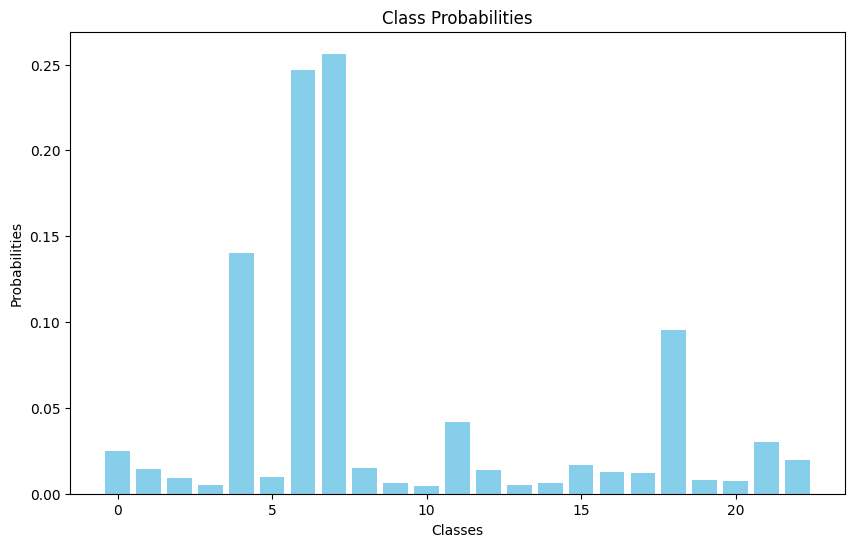

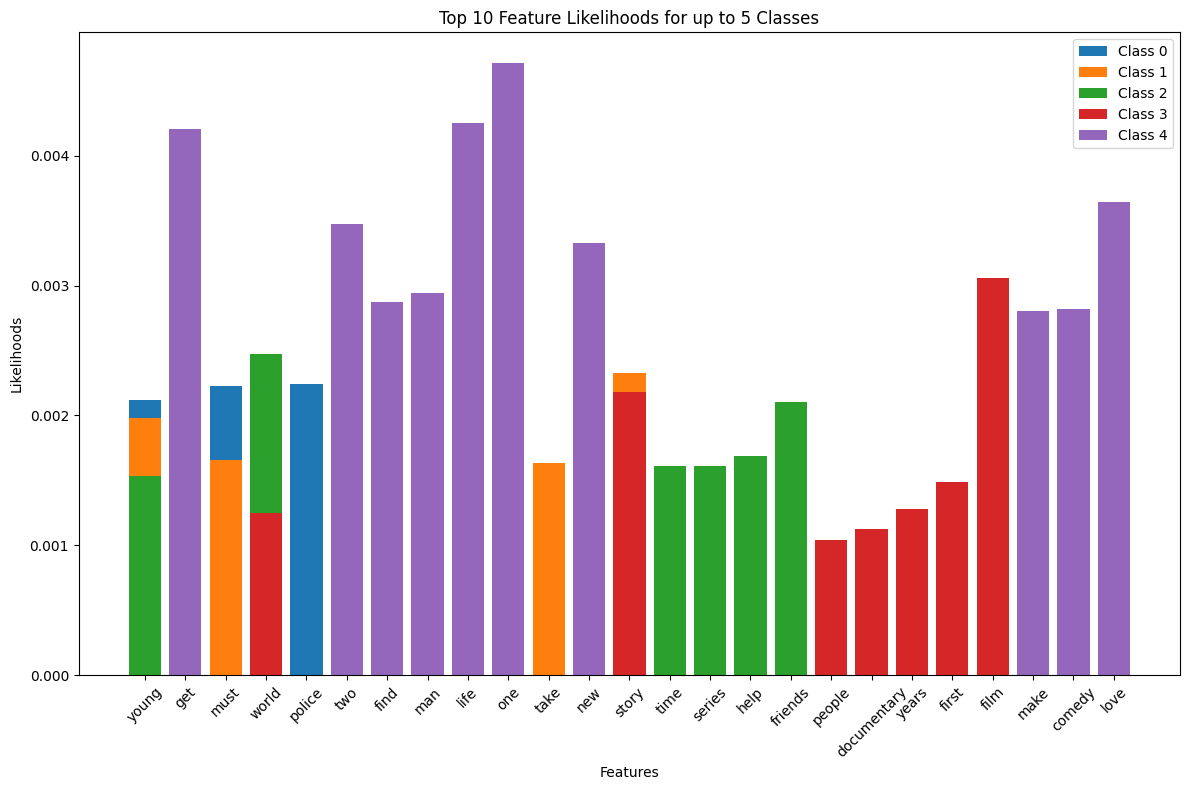

In [ ]:
import matplotlib.pyplot as plt

def visualize_class_probabilities(class_probs):
    classes = list(class_probs.keys())
    probabilities = list(class_probs.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, probabilities, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.title('Class Probabilities')
    plt.show()

def visualize_feature_likelihoods(feature_likelihoods, vocab, top_n=10, max_classes=5):
    classes = list(feature_likelihoods.keys())[:max_classes]  # Limit to max_classes
    vocab_list = np.array(vocab) if isinstance(vocab, (list, tuple, np.ndarray)) else np.array(list(vocab))

    fig, ax = plt.subplots(figsize=(12, 8))

    for cls in classes:
        likelihoods = feature_likelihoods[cls]
        top_features_indices = np.argsort(likelihoods)[-top_n:]
        top_features = vocab_list[top_features_indices]
        top_likelihoods = likelihoods[top_features_indices]

        ax.bar(top_features, top_likelihoods, label=f'Class {cls}')

    ax.set_ylabel('Likelihoods')
    ax.set_xlabel('Features')
    ax.set_title(f'Top {top_n} Feature Likelihoods for up to {max_classes} Classes')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

visualize_class_probabilities(loaded_class_probs)

visualize_feature_likelihoods(loaded_feature_likelihoods, vocab)

This function predict using the loaded model.

In [ ]:
from collections import defaultdict

def evaluate_accuracy(predictions, true_labels):
    correct = sum(pred == true for pred, true in zip(predictions, true_labels))
    return correct / len(true_labels)

def calculate_precision_recall_f1(predictions, true_labels, average='macro'):
    class_labels = np.unique(true_labels)
    precision_dict = defaultdict(int)
    recall_dict = defaultdict(int)
    f1_dict = defaultdict(int)

    for label in class_labels:
        true_positive = sum((pred == label) & (true == label) for pred, true in zip(predictions, true_labels))
        predicted_positive = sum(pred == label for pred in predictions)
        actual_positive = sum(true == label for true in true_labels)

        precision = true_positive / predicted_positive if predicted_positive != 0 else 0
        recall = true_positive / actual_positive if actual_positive != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        precision_dict[label] = precision
        recall_dict[label] = recall
        f1_dict[label] = f1_score

    if average == 'macro':
        precision = np.mean(list(precision_dict.values()))
        recall = np.mean(list(recall_dict.values()))
        f1_score = np.mean(list(f1_dict.values()))
    elif average == 'micro':
        true_positive = sum((pred == true) for pred, true in zip(predictions, true_labels))
        predicted_positive = sum(predictions)
        actual_positive = sum(true_labels)

        precision = true_positive / predicted_positive if predicted_positive != 0 else 0
        recall = true_positive / actual_positive if actual_positive != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    else:
        raise ValueError("Unsupported average type. Use 'macro' or 'micro'.")

    return precision, recall, f1_score

# Evaluate accuracy
loaded_accuracy = evaluate_accuracy(predictions, np.array(TestData['Y']))
print(f"Loaded Model Accuracy: {loaded_accuracy * 100:.2f}%")

# Evaluate precision, recall, and F1 score
precision, recall, f1_score = calculate_precision_recall_f1(predictions, np.array(TestData['Y']), average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")


Loaded Model Accuracy: 55.65%
Precision: 0.42
Recall: 0.29
F1 Score: 0.30


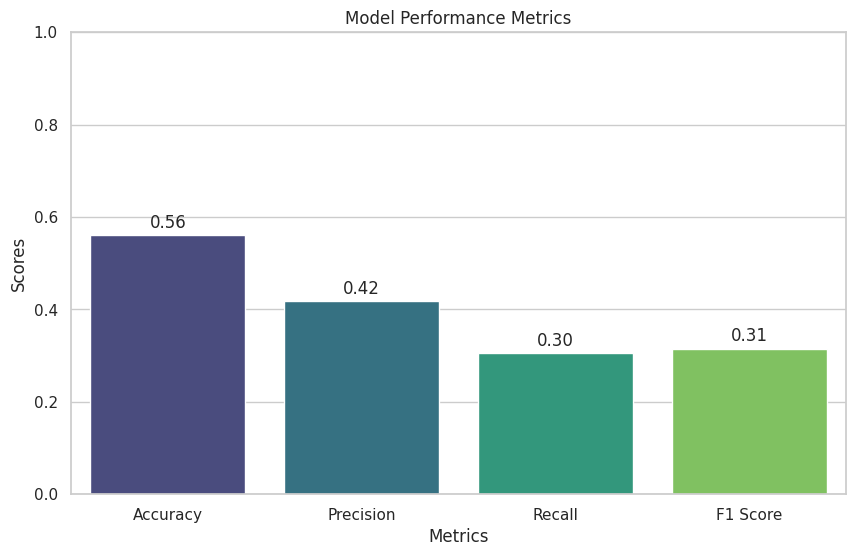

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [loaded_accuracy, precision, recall, f1_score]

# Create a DataFrame for seaborn
df = pd.DataFrame({'Metric': metrics, 'Value': values})

# Set the style
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Metric', y='Value', hue='Metric', data=df, palette='viridis', dodge=False, legend=False)

# Add values on top of bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9),
                      textcoords = 'offset points')

# Setting labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
plt.ylim(0, 1)  # Assuming all metrics are in range [0, 1]

# Show the plot
plt.show()

This part of code can be used if you want running the code without using the saved model. Beware that i**t may be need time to train the code**

In [ ]:
p_class, p_features = naive_bayes_train(bow_train, TrainData['Y'], vocab, 0.5)
predictions = naive_bayes_test(bow_test, p_class, p_features)
accuracy = evaluate_accuracy(predictions, TestData['Y'])
print(f"Accuracy: {accuracy * 100:.2f}%")
loaded_class_probs, loaded_feature_likelihoods = p_class, p_features

# **Old, My Naive Bayes**

In [ ]:
def class_probability(labels):
    total_examples = len(labels)
    probabilities = dict(Counter(labels))
    for key in probabilities.keys():
        probabilities[key] = probabilities[key] / float(total_examples)
    return probabilities

def feature_probability(feature_counts, total_word_count, vocab_size, alpha):
    total_feature_weight = feature_counts.sum()
    probability = (total_feature_weight + alpha) / (total_word_count + alpha * vocab_size)
    return probability

def naive_bayes_train(feature_matrix, labels, vocab, alpha=1.0):
    class_probs = class_probability(labels)
    unique_classes = np.unique(labels)
    num_rows, num_features = feature_matrix.shape

    feature_likelihoods = {}
    for cls in unique_classes:
        feature_likelihoods[cls] = defaultdict(list)

    for cls in unique_classes:
        row_indices = np.where(labels == cls)[0]
        class_docs = feature_matrix[row_indices, :]
        total_word_count = class_docs.sum()
        num_docs, vector_length = class_docs.shape

        for i in range(vector_length):
            feature_col = class_docs[:, i]
            feature_likelihoods[cls][i] = feature_probability(feature_col, total_word_count, len(vocab), alpha)

    return class_probs, feature_likelihoods

In [ ]:
def naive_bayes_test(feature_matrix, labels, class_probs, feature_likelihoods):
    predictions = {}
    labels_list = list(labels)

    for i in range(feature_matrix.shape[0]):
        current_features = feature_matrix[i]
        current_label = labels_list[i]
        class_predictions = {}
        for cls, cls_prob in class_probs.items():
            prob = cls_prob
            current_features_nonzero = current_features.nonzero()[1]
            for feature_index in current_features_nonzero:
                feature_count = current_features[0, feature_index]
                if feature_count > 0:
                    feature_prob = feature_likelihoods[cls][feature_index] ** feature_count
                    prob *= feature_prob
            class_predictions[cls] = prob
        sorted_predictions = sorted(class_predictions.items(), key=lambda kv: kv[1], reverse=True)
        predictions[i] = sorted_predictions

    return predictions